Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Simon Mathias Linsel"
COLLABORATORS = "Marcus Culemann, Andreas Burger, Hannah Lange"

---

!!!IMPORTANT!!!

Please comment out all the training steps you do yourself before handing in, otherwise we have to train it unnecessarily
for every student. The training for the grading will be done in the tests with our parameters.

# Exercise: Precision with custom neural networks

The scope of this exercise is to design custom neural networks which can approximate a desired function accurately.

We are interested in approximating the function in the square $[-3,3]^2$

$$-(xy+x^2+y(1-y)+8\cos(x-2y)\sin(xy+y))$$

which is a slight modification to the example presented in the lecture.

- Try to approximate this function with a simple feed-forward neural network using relu activation functions and Dense Networks. Write the function `build_simple_network` in the `CustomModel` class. 
    The input of your network should be (x,y).
- As this function involves powers and products of x and y, augment the input appropriately (up to power 2) by completing the function `augment_data` in the `Data` class and train
    the simple feed-forward neural network using relu activation functions with the same hidden layer structure as before. Does
    the performance increase?
- Now design a network which improves on this approximation by using trigonometric functions and an extended input.
Write the function `build_improved_network` in the `CustomModel` class.
    Hint: Split your network after the input and concatenate it afterwards.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Input  # imports our layers we want to use
from tensorflow.keras.models import Model  # imports our type of network

In [3]:
class Data:
    def __init__(self, num_train_points=1000000, num_test_points=100000, x_range=(-3, 3), y_range=(-3, 3),
                 granularity=0.01, use_augmented=False):
        self.x_range = x_range
        self.y_range = y_range
        self.use_augmented = use_augmented

        x = np.arange(self.x_range[0], self.x_range[1], granularity)
        y = np.arange(self.y_range[0], self.y_range[1], granularity)
        self.x, self.y = np.meshgrid(x, y)
        if self.use_augmented:
            self.grid_input = self.augment_grid()
        else:
            self.grid_input = np.vstack([self.x.reshape(-1), self.y.reshape(-1)]).transpose()

        self.z = self.calculate_function(self.x, self.y)

        self.num_train_points = num_train_points
        self.num_test_points = num_test_points
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None

        self.train_input = None
        self.test_input = None
        self.sample_grid()
        self.train_output = self.calculate_function(self.x_train, self.y_train)
        self.test_output = self.calculate_function(self.x_test, self.y_test)

        self.train_output = self.train_output.reshape(-1)
        self.test_output = self.test_output.reshape(-1)

    def sample_grid(self):
        self.x_train = np.random.uniform(self.x_range[0], self.x_range[1], (self.num_train_points, 1))
        self.y_train = np.random.uniform(self.y_range[0], self.y_range[1], (self.num_train_points, 1))
        self.x_test = np.random.uniform(self.x_range[0], self.x_range[1], (self.num_test_points, 1))
        self.y_test = np.random.uniform(self.y_range[0], self.y_range[1], (self.num_test_points, 1))

        if self.use_augmented:
            self.augment_data()
        else:
            self.train_input = np.hstack([self.x_train, self.y_train])
            self.test_input = np.hstack([self.x_test, self.y_test])

    def augment_data(self):
        """
        Augment the input to higher dimensions. Use powers of x and y up to order 2, without a bias. Overwrite both
        self.train_input and self.test_input.
        You can check if you have the correct dimensions by passing it to the model (if it fits it's probably fine)
        """
        self.train_input = np.hstack([self.x_train, self.y_train, self.x_train**2, self.x_train * self.y_train, self.y_train**2])
        self.test_input = np.hstack([self.x_test, self.y_test, self.x_test**2, self.x_test * self.y_test, self.y_test**2])

    def augment_grid(self):
        grid_x = self.x.reshape(-1)
        grid_y = self.y.reshape(-1)
        return np.vstack([grid_x, grid_y, grid_x ** 2, grid_x * grid_y, grid_y ** 2]).transpose()

    def calculate_function(self, x, y, p=1):
        return -p * (
                x * y + x ** 2 + y * (1 - y) + 8. * np.cos(x - 2. * y) * np.sin(
            x * y + y))

    def plot_function(self):
        plt.figure(figsize=(10, 10))
        plt.contourf(self.x, self.y, self.z)
        plt.colorbar()
        plt.title("Original Data")
        plt.show()


In [29]:

class CustomModel:
    def __init__(self, data: Data):
        self.data = data
        self.model = None
        self.history = None

    def build_improved_network(self, verbose=False):
        """
        Build the improved Network from Dense, Lambda and Concatenate Layers. Improve this network until it outperforms
        the Dense Network.
        Hint: You need to compile the model as well.
        """
        if not self.data.use_augmented:
            raise RuntimeError("This network only works with the augmented data.")

        input_shape = (self.data.train_input.shape[1],) 
    
        input_network = Input(shape=input_shape)
        
        x1 = Dense(units=32, activation='relu')(input_network)
        x1 = Lambda(lambda x: tf.math.sin(x))(x1)
        
        x2 = Dense(units=32, activation='relu')(input_network)
        x2 = Lambda(lambda x: tf.math.sin(x))(x2)
        
        
        x3 = Dense(units=32, activation='relu')(input_network)
        
        concat = tf.keras.layers.concatenate([x1,x2,x3])
        
        output_network = Dense(units=1)(concat)
        
        self.model = Model(inputs=input_network, outputs=output_network)
        self.model.compile(loss='mse', optimizer='adam')

    def build_simple_network(self, verbose=False):
        """
        Build a Dense, feedforward network that can deal with both simple and augmented data.
        Hint: You need to compile the model as well. You can use the self.data.use_augmented flag.
        """
        input_shape = (self.data.train_input.shape[1],) 
    
        input_network = Input(shape=input_shape)
        
        x = Dense(units=32, activation='relu')(input_network)
        x = Dense(units=32, activation='relu')(x)
        x = Dense(units=32, activation='relu')(x)
        
        output_network = Dense(units=1)(x)
        
        self.model = Model(inputs=input_network, outputs=output_network)
        self.model.compile(loss='mse', optimizer='adam')

    def fit(self, epochs=100, batch_size=10000, verbose=0):
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                                                         patience=5, min_lr=0.000001)

        fit = self.model.fit(self.data.train_input, self.data.train_output,
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=verbose,
                             validation_data=(self.data.test_input, self.data.test_output), callbacks=[reduce_lr])
        self.history = fit.history

    def visualize(self):
        self.data.plot_function()
        prediction = self.model.predict(self.data.grid_input)
        prediction = prediction.reshape(*self.data.x.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(self.data.x, self.data.y, prediction)
        plt.colorbar()
        plt.title('Prediction')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.contourf(self.data.x, self.data.y, prediction - self.data.z)
        plt.colorbar()
        plt.title('Deviation from Original Data')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.hist((prediction - self.data.z).reshape(-1), bins=100, density=True)
        plt.title('Distribution of Deviation from Original Data')
        plt.show()

In [30]:
epochs = 100

Build the Data without the augmentation and apply the simple model to it. You can visualize it using the class method.
Hint: The fit method has a verbose flag to output the fitting process.

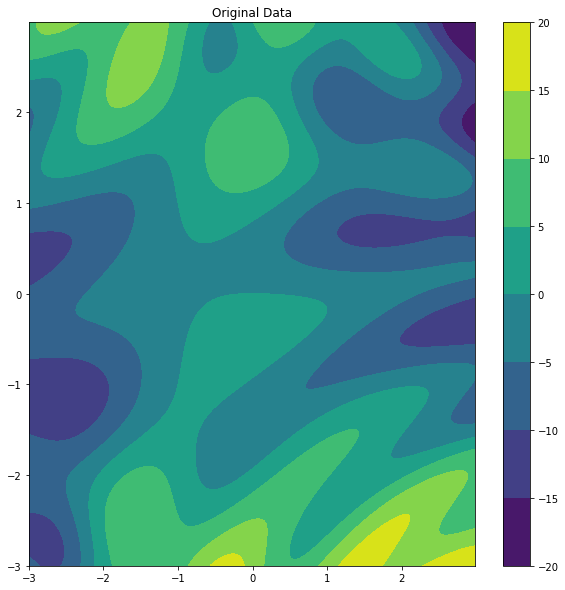

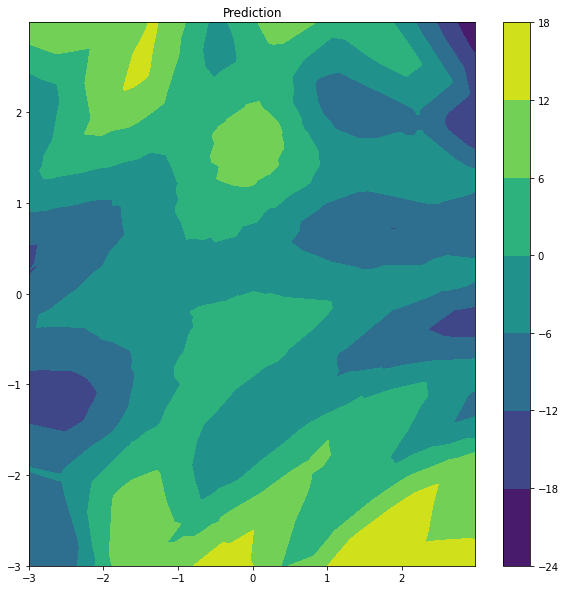

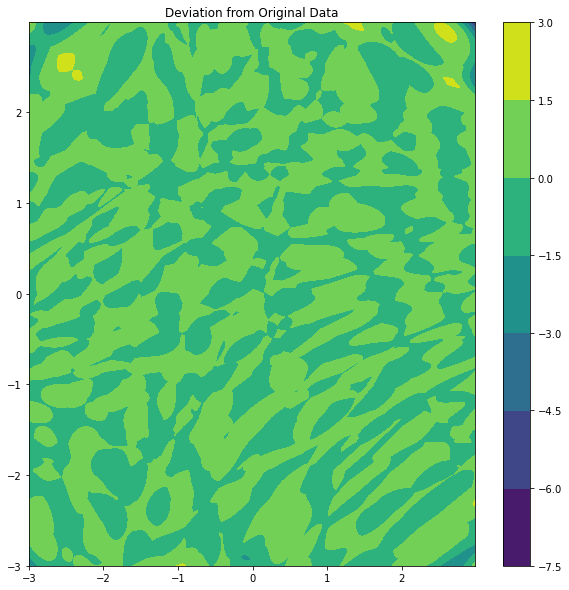

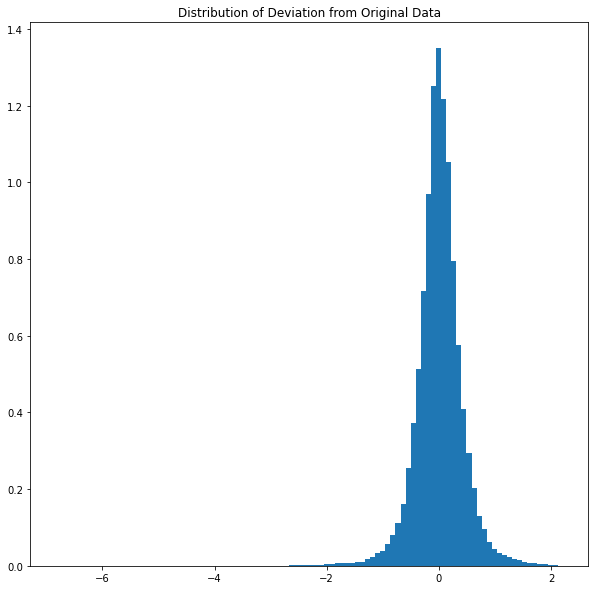

In [20]:
data = Data()

simple_model = CustomModel(data)
simple_model.build_simple_network()
simple_model.fit()
simple_model.visualize()

Build the Data including the augmentation and apply the simple model to it. You can visualize it using the class method.

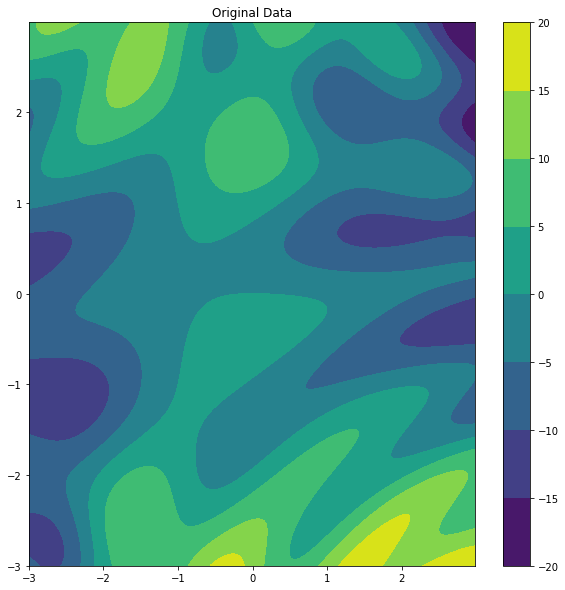

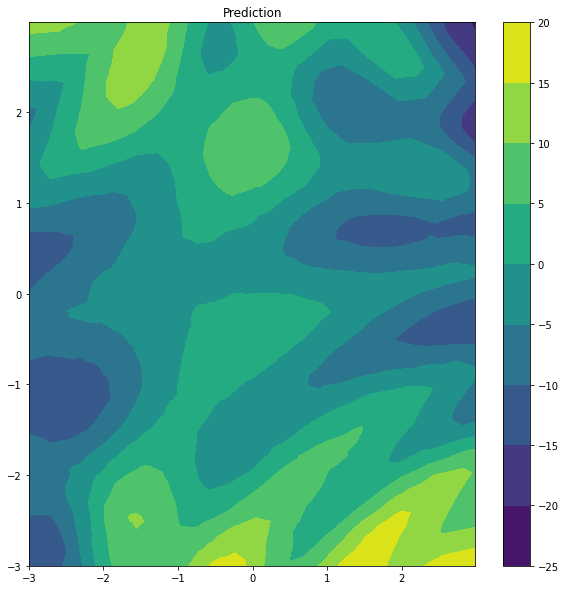

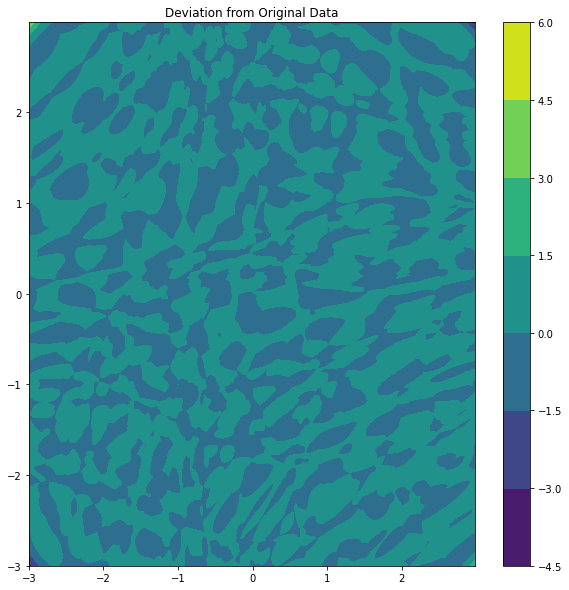

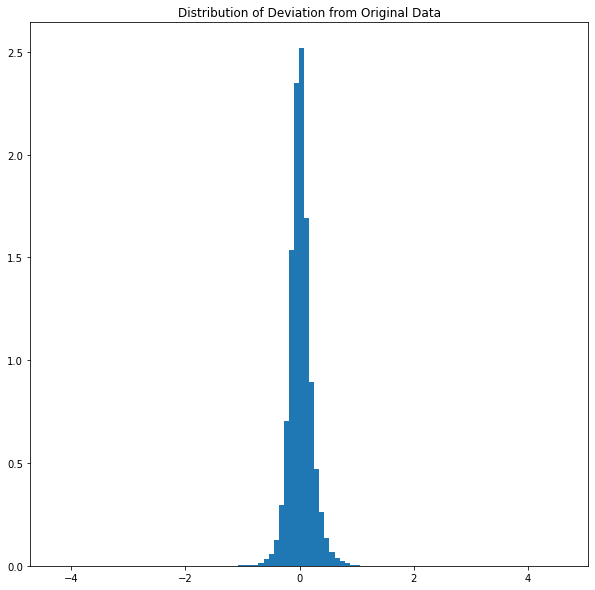

In [23]:
augmented_data = Data(use_augmented=True)

simple_model = CustomModel(augmented_data)
simple_model.build_simple_network()
simple_model.fit()
simple_model.visualize()

Build the Data including the augmentation and apply the improved model to it. You can visualize it using the class
method. Compare the value loss to the standard network and improve the performance until it outperforms the simple
Network.
Hint: You probably need 1.000.000 training points for the complex network to perform well.

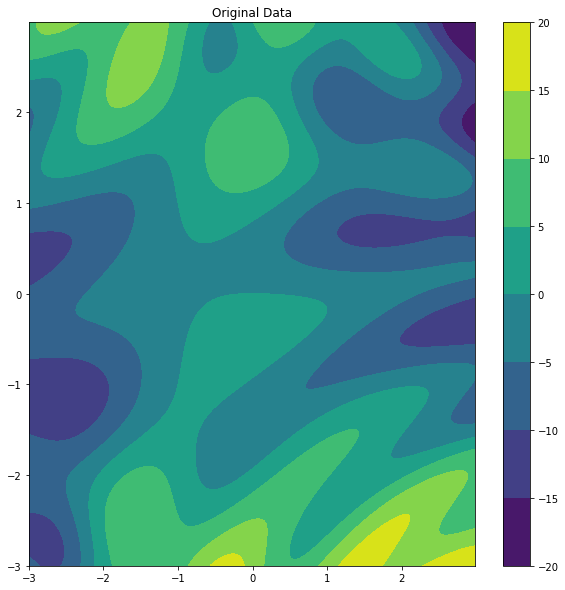

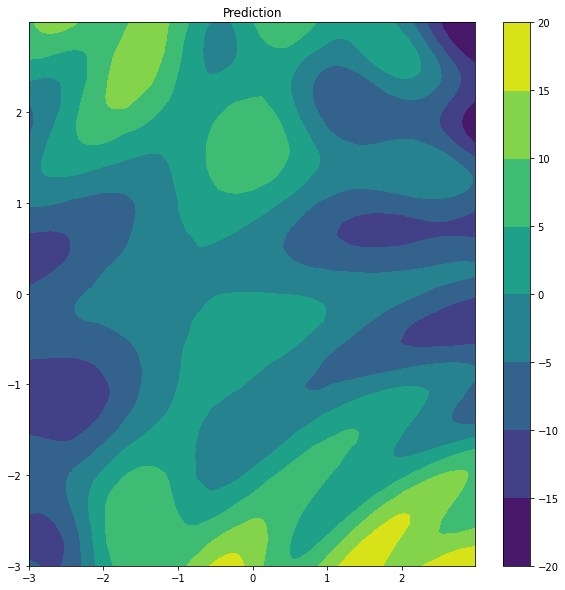

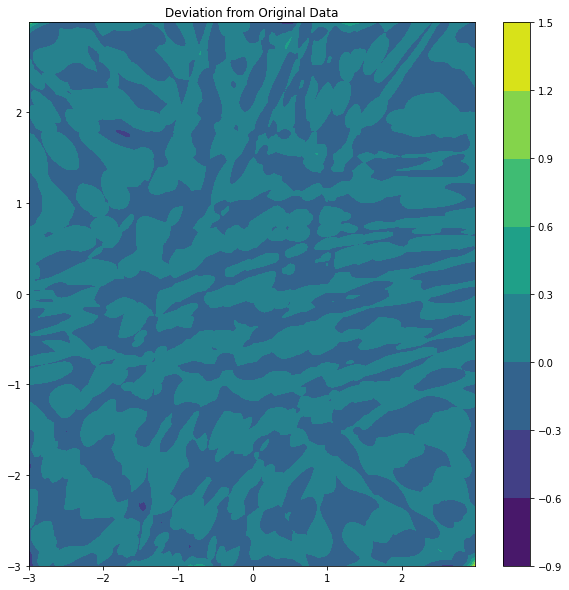

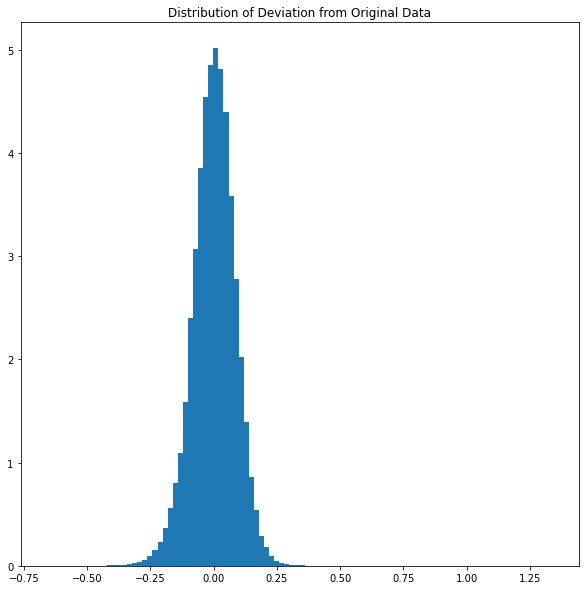

In [31]:
augmented_data = Data(use_augmented=True)

improved_model = CustomModel(augmented_data)
improved_model.build_improved_network()
improved_model.fit()
improved_model.visualize()

In [ ]:
# Your code will be autograded here.


In [ ]:
# Your code will be autograded here.


In [ ]:
# Your code will be autograded here.


In [ ]:
# Your code will be autograded here.